In [1]:
import math
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [2]:
url = 'https://github.com/HenryZW/Tennis-Match-Prediction-Model/blob/main/Wimbledon_featured_matches.csv'
wfm = pd.read_csv(url)

In [3]:
def convert_to_elapsed_time(timestamp):
    return timestamp.strftime('%H:%M:%S')  # Format datetime.time object to "hh:mm:ss"

wfm['elapsed_time'] = wfm['elapsed_time'].apply(convert_to_elapsed_time)

nan_locations = wfm.isna()
for col in wfm.columns:
    for idx, is_nan in nan_locations[col].items():
        if is_nan:
            match_id = wfm.loc[idx, 'match_id']
            column_name = col
            if wfm.loc[idx+1, 'serve_no'] == 2:
                failed_first_serve = True
            else:
                failed_first_serve = False
            double_fault = True if wfm.loc[idx, 'p1_double_fault'] == wfm.loc[idx, 'p2_double_fault'] else False
            elapsed_time = wfm.loc[idx, 'elapsed_time'] if 'elapsed_time' in wfm.columns else None
            print(f"NaN found in Match ID: {match_id[-4:]}, Column Name: {column_name}, Elapsed Time: {elapsed_time}, Is failed first serve? {failed_first_serve}, Is double fault? {double_fault}")

NaN found in Match ID: 1301, Column Name: speed_mph, Elapsed Time: 00:32:57, Is failed first serve? False, Is double fault? False
NaN found in Match ID: 1301, Column Name: speed_mph, Elapsed Time: 02:06:20, Is failed first serve? False, Is double fault? False
NaN found in Match ID: 1301, Column Name: speed_mph, Elapsed Time: 02:14:53, Is failed first serve? False, Is double fault? False
NaN found in Match ID: 1301, Column Name: speed_mph, Elapsed Time: 02:28:21, Is failed first serve? False, Is double fault? False
NaN found in Match ID: 1301, Column Name: speed_mph, Elapsed Time: 02:53:10, Is failed first serve? False, Is double fault? False
NaN found in Match ID: 1301, Column Name: speed_mph, Elapsed Time: 02:55:10, Is failed first serve? True, Is double fault? False
NaN found in Match ID: 1301, Column Name: speed_mph, Elapsed Time: 03:05:04, Is failed first serve? False, Is double fault? True
NaN found in Match ID: 1301, Column Name: speed_mph, Elapsed Time: 03:13:12, Is failed first

In [4]:
def mean_imputation(dataframe_column):
    mean_value = dataframe_column.mean(skipna=True)
    dataframe_column.fillna(mean_value, inplace=True)
    return dataframe_column

def mode_imputation(dataframe_column):
    mode_value = dataframe_column.mode()[0]
    dataframe_column.fillna(mode_value, inplace=True)
    return dataframe_column

def apply_imputation(df):
    for col in df.columns:
        if df[col].isna().any():
            if df[col].dtype == 'O':
                df[col] = mode_imputation(df[col])
            else:
                df[col] = mean_imputation(df[col])
    return df

def label_encode_column(df, column_name):
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return df

    label_encoder = LabelEncoder()

    # Check if the column contains object (string) data and has limited unique values, if so, apply label encoding
    if df[column_name].dtype == 'object' and len(df[column_name].unique()) <= 16:

        df[column_name] = label_encoder.fit_transform(df[column_name])
        print(f"Label encoding applied to column '{column_name}'.")
    else:
        print(f"Column '{column_name}' does not meet the criteria for label encoding.")
    return df

def replace_column_value(df, column_name, old_value, new_value):
    df[column_name] = df[column_name].replace(old_value, new_value)
    return df

wfm["speed_mph"] = mean_imputation(wfm["speed_mph"])
wfm["serve_width"] = mode_imputation(wfm["serve_width"])
wfm["serve_depth"] = mode_imputation(wfm["serve_depth"])
wfm["return_depth"] = mode_imputation(wfm["return_depth"])
wfm = replace_column_value(wfm,"p1_score","AD",45)
wfm = replace_column_value(wfm,"p2_score","AD",45)
wfm = replace_column_value(wfm,"winner_shot_type","F",1)
wfm = replace_column_value(wfm,"winner_shot_type","B",2)
wfm = label_encode_column(wfm,"serve_width")
wfm = label_encode_column(wfm,"serve_depth")
wfm = label_encode_column(wfm,"return_depth")

Label encoding applied to column 'serve_width'.
Label encoding applied to column 'serve_depth'.
Label encoding applied to column 'return_depth'.


In [5]:
match_dfs = {}
match_ids = wfm["match_id"].unique()
for match_id in match_ids:
    match_dfs[match_id] = wfm[wfm["match_id"] == match_id]

In [6]:
raw_match_dfs = match_dfs   # Save a raw data copy of the original dataframe

def time_to_minutes(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    total_minutes = hours * 60 + minutes + seconds / 60.0
    return total_minutes

for match_id in match_ids:
# Here you can modify values in each matches    
    match_dfs[match_id].loc[:,'estimated_time'] = match_dfs[match_id].loc[:,'point_no']*match_dfs[match_id].loc[:,'rally_count']
    
    match_dfs[match_id].loc[:,'cumulative_points_diff'] = match_dfs[match_id].loc[:,'p1_points_won']-match_dfs[match_id].loc[:,'p2_points_won']
    
    match_dfs[match_id].loc[:,'run_distance_difference'] = match_dfs[match_id].loc[:,'p1_distance_run']-match_dfs[match_id].loc[:,'p2_distance_run']
    match_dfs[match_id].loc[:,'run_distance_difference'] = match_dfs[match_id].loc[:,'run_distance_difference'] / match_dfs[match_id]['run_distance_difference'].max()
    
    match_dfs[match_id].loc[:,'ace'] = match_dfs[match_id].loc[:,'p1_ace']-match_dfs[match_id].loc[:,'p2_ace']
    
    match_dfs[match_id].loc[:,'double_fault'] = match_dfs[match_id].loc[:,'p1_double_fault']-match_dfs[match_id].loc[:,'p2_double_fault']
    
    match_dfs[match_id].loc[:,'unf_err'] = match_dfs[match_id].loc[:,'p1_unf_err']-match_dfs[match_id].loc[:,'p2_unf_err']
    
    match_dfs[match_id].loc[:,'p1_break_pt_result'] = match_dfs[match_id].loc[:,'p1_break_pt_won']-match_dfs[match_id].loc[:,'p1_break_pt_missed']
    match_dfs[match_id].loc[:,'p2_break_pt_result'] = match_dfs[match_id].loc[:,'p2_break_pt_won']-match_dfs[match_id].loc[:,'p2_break_pt_missed']
    
    match_dfs[match_id].loc[:,'elapsed_minutes'] = match_dfs[match_id].loc[:,'elapsed_time'].apply(time_to_minutes)
    
    match_dfs[match_id].loc[:,'speed_mph'] = match_dfs[match_id].loc[:,'speed_mph'] / match_dfs[match_id]['speed_mph'].max()
    
    match_dfs[match_id].loc[:,'p1_consistency'] = 0
    match_dfs[match_id].loc[:,'p2_consistency'] = 0
    for index, row in match_dfs[match_id].iterrows():
        if index<=4:
            p1_consistency_count = 0
            p2_consistency_count = 0
        else:
            p1_consistency_count = match_dfs[match_id].loc[index-3:index, 'point_victor'].eq(1).sum()
            p2_consistency_count = match_dfs[match_id].loc[index-3:index, 'point_victor'].eq(2).sum()
        match_dfs[match_id].loc[index, 'p1_consistency'] = p1_consistency_count
        match_dfs[match_id].loc[index, 'p2_consistency'] = p2_consistency_count
        
    match_dfs[match_id]['point_victor_result'] = match_dfs[match_id]['point_victor'].shift(-1)
    match_dfs[match_id]['point_victor_result'].fillna(method='ffill', inplace=True)

C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id].loc[:,'estimated_time'] = match_dfs[match_id].loc[:,'point_no']*match_dfs[match_id].loc[:,'rally_count']
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id].loc[:,'cumulative_points_diff'] = match_dfs[match_id].loc[:,'p1_points_won']-match_dfs[match_id].loc[:,'p2_points_won']
C:\Users\zhuzi\AppD

C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id].loc[:,'p1_break_pt_result'] = match_dfs[match_id].loc[:,'p1_break_pt_won']-match_dfs[match_id].loc[:,'p1_break_pt_missed']
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id].loc[:,'p2_break_pt_result'] = match_dfs[match_id].loc[:,'p2_break_pt_won']-match_dfs[match_id].loc[:,'p2_break_pt_missed'

C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'] = match_dfs[match_id]['point_victor'].shift(-1)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'].fillna(method='ffill', inplace=True)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'] = match_dfs[match_id]['point_victor'].shift(-1)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'].fillna(method='ffill', inplace=True)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'] = match_dfs[match_id]['point_victor'].shift(-1)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'].fillna(method='ffill', inplace=True)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'] = match_dfs[match_id]['point_victor'].shift(-1)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'].fillna(method='ffill', inplace=True)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'] = match_dfs[match_id]['point_victor'].shift(-1)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'].fillna(method='ffill', inplace=True)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'] = match_dfs[match_id]['point_victor'].shift(-1)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'].fillna(method='ffill', inplace=True)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'] = match_dfs[match_id]['point_victor'].shift(-1)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_dfs[match_id]['point_victor_result'].fillna(method='ffill', inplace=True)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\2771198785.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [7]:
test_match = match_dfs.pop('2023-wimbledon-1701')

In [8]:
match_dfs['2023-wimbledon-1301'].columns.tolist()

['match_id',
 'player1',
 'player2',
 'elapsed_time',
 'set_no',
 'game_no',
 'point_no',
 'p1_sets',
 'p2_sets',
 'p1_games',
 'p2_games',
 'p1_score',
 'p2_score',
 'server',
 'serve_no',
 'point_victor',
 'p1_points_won',
 'p2_points_won',
 'game_victor',
 'set_victor',
 'p1_ace',
 'p2_ace',
 'p1_winner',
 'p2_winner',
 'winner_shot_type',
 'p1_double_fault',
 'p2_double_fault',
 'p1_unf_err',
 'p2_unf_err',
 'p1_net_pt',
 'p2_net_pt',
 'p1_net_pt_won',
 'p2_net_pt_won',
 'p1_break_pt',
 'p2_break_pt',
 'p1_break_pt_won',
 'p2_break_pt_won',
 'p1_break_pt_missed',
 'p2_break_pt_missed',
 'p1_distance_run',
 'p2_distance_run',
 'rally_count',
 'speed_mph',
 'serve_width',
 'serve_depth',
 'return_depth',
 'estimated_time',
 'cumulative_points_diff',
 'run_distance_difference',
 'ace',
 'double_fault',
 'unf_err',
 'p1_break_pt_result',
 'p2_break_pt_result',
 'elapsed_minutes',
 'p1_consistency',
 'p2_consistency',
 'point_victor_result']

In [9]:
# Combine the seperated dataframes back to a single one for feature selection
match_dfs_modified = pd.concat(match_dfs.values(), ignore_index=True)

# Separate features (X) and target (y_wfm) for training
X = match_dfs_modified.drop([
                      'serve_width',
                      'speed_mph',
                      'elapsed_minutes',
                      'run_distance_difference',
                      'point_victor_result',
                      'match_id',
                      'player1', 'player2',
                      'elapsed_time',
                      'p1_distance_run', 'p2_distance_run',
                      'p1_points_won','p2_points_won',
                      ], axis=1)
y_wfm = match_dfs_modified['point_victor_result']

In [10]:
# Initialize Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X, y_wfm)

# Extract feature importances
feature_importances = rf_clf.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]  # Sort indices by importance

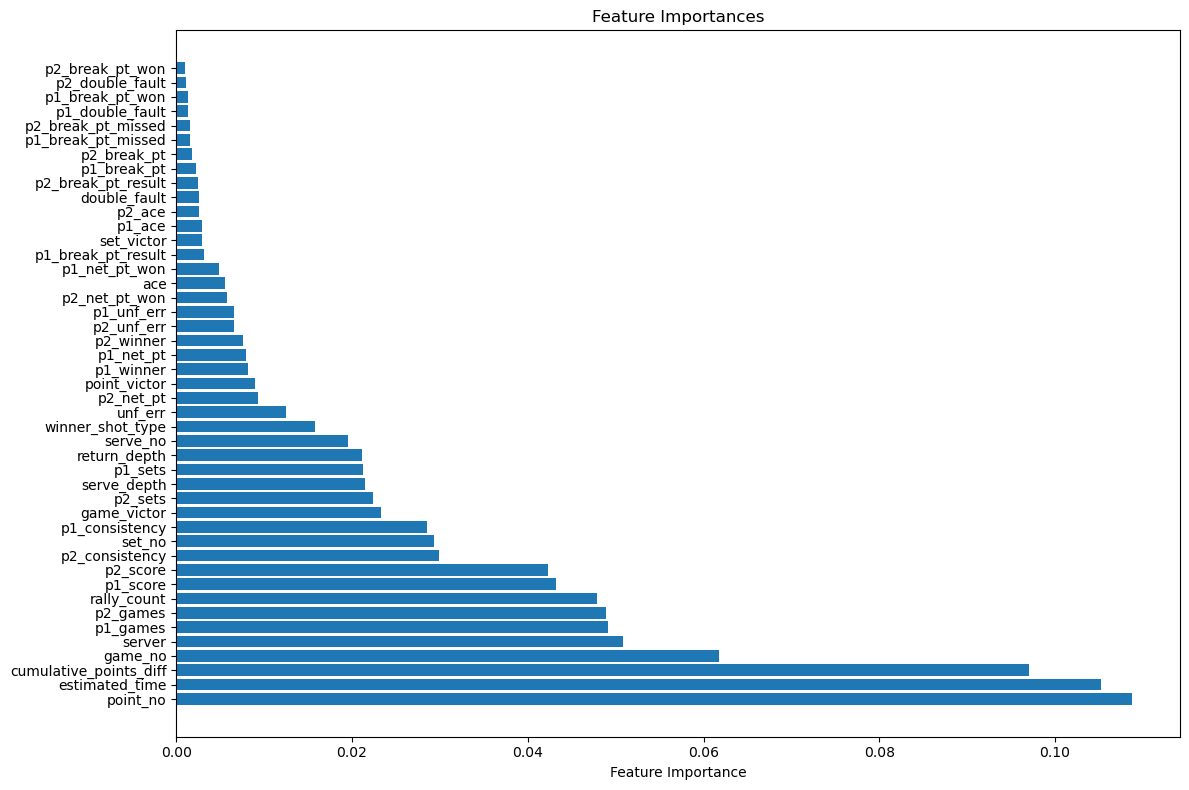

In [11]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(X.shape[1]), feature_importances[sorted_indices], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_indices], fontsize=10, ha='right')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [12]:
k = 14  # Number of top features to select
top_features = X.columns[sorted_indices][:k]

# Subset X with top features
X_wfm_selected = X[top_features]

auxiliary_df = pd.read_pickle('m_2010s_modified.pkl')
X_auxiliary_selected = auxiliary_df[top_features]
X_auxiliary_selected = apply_imputation(X_auxiliary_selected)
X_auxiliary_selected = X_auxiliary_selected.sample(n=10000, random_state=37)
y_auxiliary = auxiliary_df['point_victor_result']
y_auxiliary = y_auxiliary.sample(n=10000, random_state=37)

X_selected = pd.concat([X_wfm_selected, X_auxiliary_selected], ignore_index=True)
y = pd.concat([y_wfm, y_auxiliary], ignore_index=True)
X_selected.info()
print('\n')
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16950 entries, 0 to 16949
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   point_no                16950 non-null  int64  
 1   estimated_time          16950 non-null  float64
 2   cumulative_points_diff  16950 non-null  int64  
 3   game_no                 16950 non-null  int64  
 4   server                  16950 non-null  int64  
 5   p1_games                16950 non-null  int64  
 6   p2_games                16950 non-null  float64
 7   rally_count             16950 non-null  float64
 8   p1_score                16950 non-null  object 
 9   p2_score                16950 non-null  object 
 10  p2_consistency          16950 non-null  float64
 11  set_no                  16950 non-null  int64  
 12  p1_consistency          16950 non-null  float64
 13  game_victor             16950 non-null  int64  
dtypes: float64(5), int64(7), object(2)
mem

C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\3278723546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_column.fillna(mean_value, inplace=True)
C:\Users\zhuzi\AppData\Local\Temp\ipykernel_11480\3278723546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = mean_imputation(df[col])


In [13]:
# All the Hyperparameter tuning (with grid search) has an argument of n_jobs=-1. This will eat up all avaliable CPU resources to accelerate the code.
# Delete this argument if you do not want this feature.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [10, 20, 30]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_selected, y)

optimized_parameters = grid_search_rf.best_params_
accuracy_rf = grid_search_rf.best_score_
print("Best Parameters:", optimized_parameters)
print("Best Cross-Validation Accuracy:", grid_search_rf.best_score_)
rf_clf_best = grid_search_rf.best_estimator_

Best Parameters: {'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 3, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.6292625368731564


In [14]:
# Initialize SVM classifier
svm_clf = SVC(kernel='rbf', random_state=42)

# Create a pipeline with StandardScaler and SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', svm_clf)
])

# Define the parameter grid for SVM
param_grid_svm = {
    'svm__C': [0.1, 1.0, 10.0],  # Regularization parameter
    'svm__gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf' kernel
}

# Perform grid search with cross-validation for SVM
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_selected, y)

print("Best Parameters for SVM:", grid_search_svm.best_params_)
print("Best Cross-Validation Accuracy for SVM:", grid_search_svm.best_score_)

svm_clf_best = grid_search_svm.best_estimator_

Best Parameters for SVM: {'svm__C': 10.0, 'svm__gamma': 'scale'}
Best Cross-Validation Accuracy for SVM: 0.6146312684365782


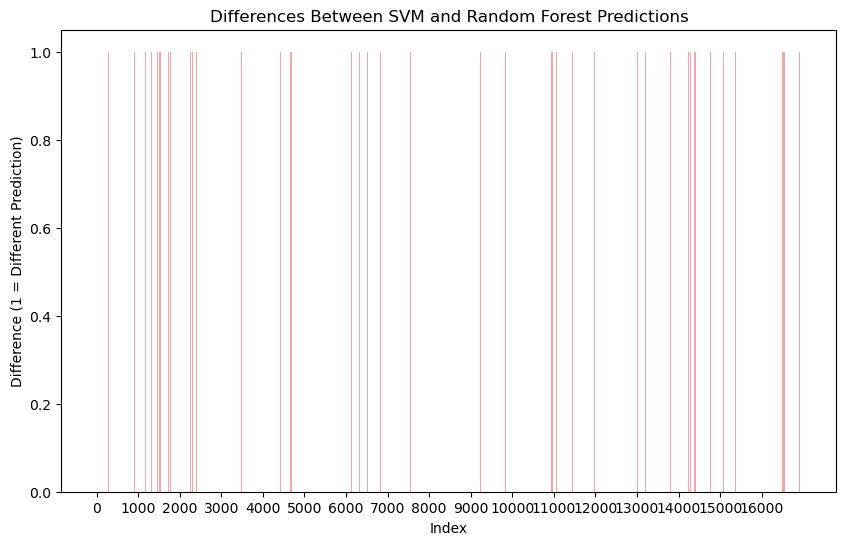

In [15]:
svm_list = grid_search_svm.predict(X_selected).astype(int)
rf_list = grid_search_rf.predict(X_selected).astype(int)

# Find indices where the lists differ
differ_indices = [i for i in range(len(svm_list)) if svm_list[i] != rf_list[i]]

# Create a bar chart to show the differences at each index
plt.figure(figsize=(10, 6))
plt.bar(range(len(svm_list)), [1 if i in differ_indices else 0 for i in range(len(svm_list))], color='lightcoral', alpha=0.7)
plt.title('Differences Between SVM and Random Forest Predictions')
plt.xlabel('Index')
plt.ylabel('Difference (1 = Different Prediction)')
plt.xticks(range(0, len(svm_list), 1000))
plt.show()

In [16]:
# Base estimators for stacking (SVM and Random Forest)
estimators = [
    ('svm', svm_clf_best),  # Use the best SVM estimator from GridSearchCV
    ('rf', rf_clf_best)
]

# Meta-estimator (Logistic Regression) for stacking with hyperparameter tuning
meta_estimator = GridSearchCV(LogisticRegression(),{'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization parameter
                                                    'solver': ['liblinear', 'lbfgs']  # Optimization algorithm
                                                    }, cv=5, scoring='accuracy', n_jobs=-1)

# Initialize Stacking Classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_estimator, cv=5)

# Train Stacking Classifier on the selected features
stacking_clf.fit(X_selected, y)

# Split the data to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Evaluate Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print("Stacking Classifier Accuracy after Hyperparameter Tuning:", accuracy_stacking)

Stacking Classifier Accuracy after Hyperparameter Tuning: 0.6607669616519174


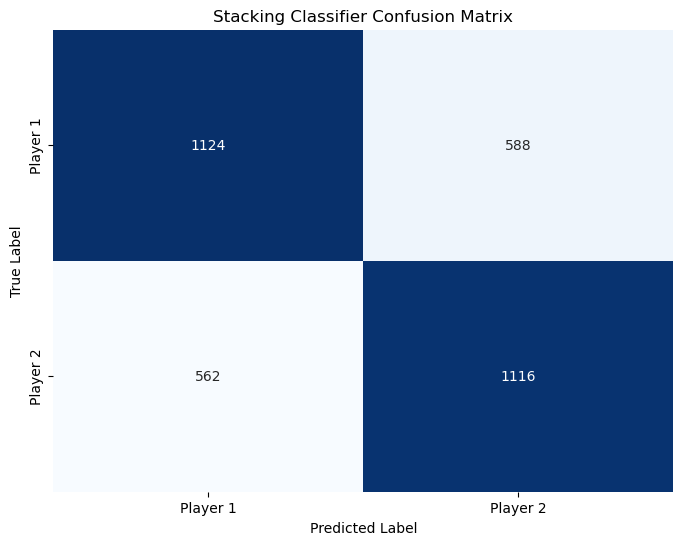

In [17]:
# Generate predictions using Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_test)

# Confusion matrix for Stacking Classifier
stacking_cm = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(stacking_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Stacking Classifier Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Player 1', 'Player 2'])
plt.yticks([0.5, 1.5], ['Player 1', 'Player 2'])
plt.show()

Stacking Classifier Accuracy: 0.5778443113772455
Wrong Predictions for points won by Player1: 76
Wrong Predictions for points won by Player2: 64


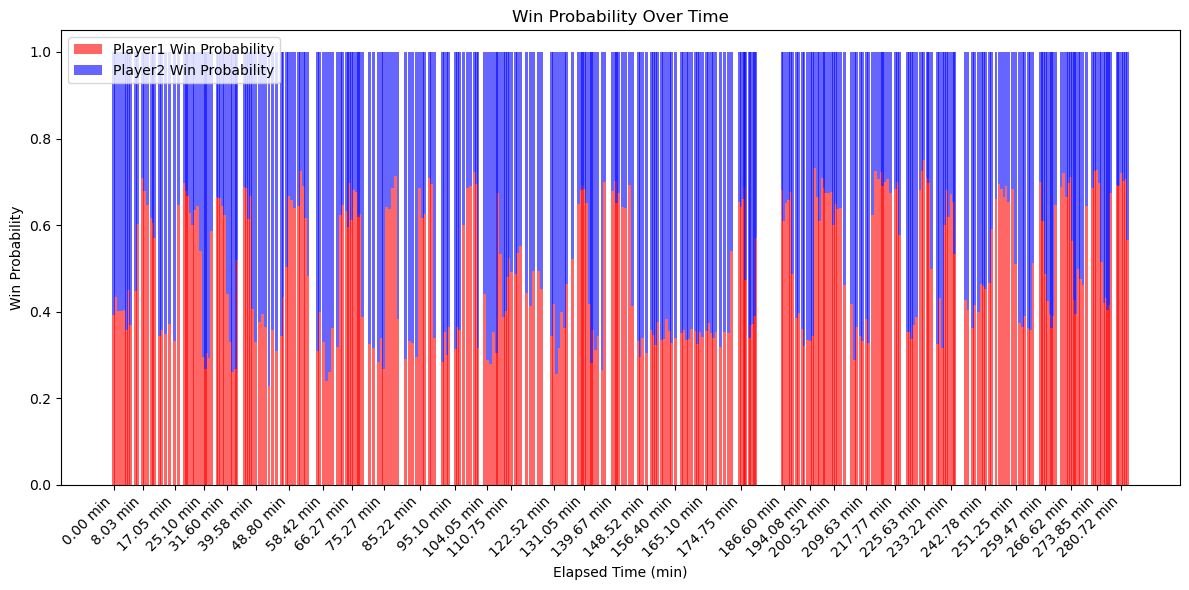

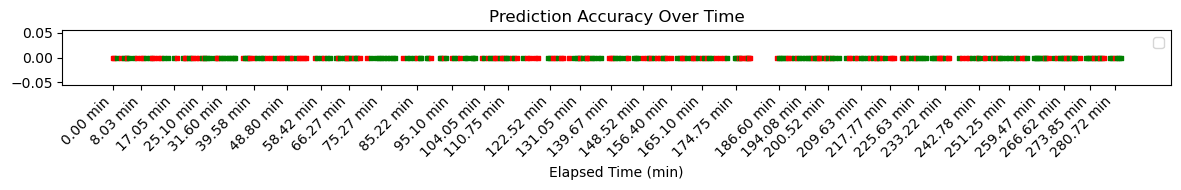

In [18]:
m1701_X_test = test_match[top_features]
m1701_y_pred = stacking_clf.predict(m1701_X_test)

y_prob = stacking_clf.predict_proba(m1701_X_test)
player1_win_prob = y_prob[:, 0]
player2_win_prob = y_prob[:, 1]

m1701_y_test = test_match["point_victor_result"].tolist()

m1701_accuracy = accuracy_score(m1701_y_test, m1701_y_pred)
print("Stacking Classifier Accuracy:", m1701_accuracy)

time_stamp = test_match["elapsed_minutes"].tolist()

# Check the number of wrong predictions for each player
wrong_player1_count = 0
wrong_player2_count = 0

for i in range(1, len(m1701_y_test)):
    actual_winner = m1701_y_test[i]
    predicted_winner = m1701_y_pred[i]
    
    if actual_winner != predicted_winner:
        if actual_winner == 1:
            wrong_player1_count += 1
        else:
            wrong_player2_count += 1

print(f"Wrong Predictions for points won by Player1: {wrong_player1_count}")
print(f"Wrong Predictions for points won by Player2: {wrong_player2_count}")

# Plot the winning probability predicted by the model when making a wrong prediction
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(time_stamp, player1_win_prob, color='red', alpha=0.6, label='Player1 Win Probability')
ax.bar(time_stamp, player2_win_prob, color='blue', alpha=0.6, label='Player2 Win Probability', bottom=player1_win_prob)
x_ticks = time_stamp[::10]
x_tick_labels = [f'{ts:.2f} min' for ts in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels, rotation=45, ha='right')
ax.set_xlabel('Elapsed Time (min)')
ax.set_ylabel('Win Probability')
ax.set_title('Win Probability Over Time')
ax.legend()
plt.tight_layout()
plt.show()

# Plot correct predictions as dgreen dots, and wrong ones with red dots
fig, ax = plt.subplots(figsize=(12, 2))
for i in range(len(m1701_y_test)):
    actual_winner = m1701_y_test[i]
    predicted_winner = m1701_y_pred[i]
    correct_prediction = (actual_winner == predicted_winner)
    
    marker = ','
    marker_color = 'green' if correct_prediction else 'red'
    
    ax.scatter(time_stamp[i], 0, color=marker_color, marker=marker, s=5)

x_ticks = time_stamp[::10]
x_tick_labels = [f'{ts:.2f} min' for ts in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels, rotation=45, ha='right')
ax.set_xlabel('Elapsed Time (min)')
ax.set_title('Prediction Accuracy Over Time')
handles, labels = ax.get_legend_handles_labels()
filtered_handles = [handles[i] for i, label in enumerate(labels) if label not in labels[:i]]
filtered_labels = [label for i, label in enumerate(labels) if label not in labels[:i]]
ax.legend(filtered_handles, filtered_labels)
plt.tight_layout()
plt.show()

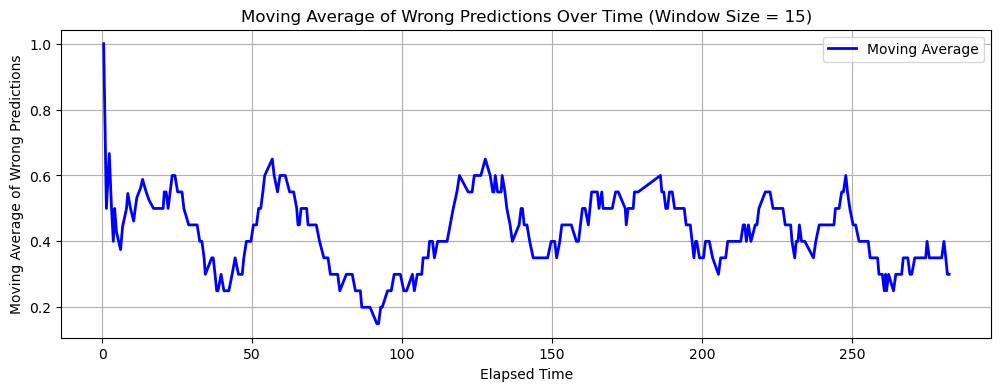

In [19]:
wrong_prediction_counts = []
for i in range(1, len(m1701_y_test)):
    actual_winner = m1701_y_test[i]
    predicted_winner = m1701_y_pred[i]
    
    if actual_winner != predicted_winner:
        wrong_prediction_counts.append(1)
    else:
        wrong_prediction_counts.append(0)

prediction_test_match = {'timestamp': time_stamp[1:], 'wrong_predictions': wrong_prediction_counts}

# Convert to pd dataframes to use .rolling() for moving average
prediction_test_match_df = pd.DataFrame(prediction_test_match)
prediction_test_match_df['moving_average'] = prediction_test_match_df['wrong_predictions'].rolling(window=20, min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(prediction_test_match_df['timestamp'], prediction_test_match_df['moving_average'], color='blue', linewidth=2, label='Moving Average')
plt.xlabel('Elapsed Time')
plt.ylabel('Moving Average of Wrong Predictions')
plt.title('Moving Average of Wrong Predictions Over Time (Window Size = 15)')
plt.grid(True)
plt.legend()
plt.show()